# Working with actual evapotranspiration files from GLEAM

Source:  
https://www.gleam.eu/ 

We will:
- Import modules that are important to complete the work.
- Load a couple of GLEAM files.
- Represent them.
- Retrieve information for specific locations.

### Do not forget to run all cells in order, from top to bottom. Failing to do so may cause errors.
### AI Large Language Models (such as deepseek) can help you a lot doing this.

## Modules

Some useful modules are:
- `pandas` (https://pandas.pydata.org/docs/getting_started/intro_tutorials/): to work with tabular data (including import and export). It is the "Microsoft Excel" of Python.
- `matplotlib` (https://matplotlib.org/stable/plot_types/index.html): to create figures (plots).
- `numpy`: to perform calculations efficiently.
- `pathlib`: not as important. To handle folder and file paths.
- `xarray`: general package to handle multidimensional matrices (such as meteorological data, with time, latitude, longitude). Low level.
- `meteoraster`: specific to handle multidimensional meteorological forecasts (time, ensemble member, forecast horizon, latitude, and longitude). High level.


## Import modules

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path 
import xarray as xr
from meteoraster import MeteoRaster # Only works if you are working with the shu_hydrolgy environment!

## Function to read the GLEAM files
Let's now create a function that we can use several times to read GLEAM files.  
Those are in the netCDF format, which is a common standard for meteorological data.

The function is called `read_gleam` and takes the file path as an input.  
It returns an "object" of the `MeteoRaster` type.

In [18]:
def read_gleam(file):
    data = {}
    with xr.open_dataset(file) as ds:
            data['latitudes'] = ds.lat.data
            data['longitudes'] = ds.lon.data
            data['productionDates'] = ds.time.data
            data['leadtimes'] = np.array([pd.DateOffset(days=0)])
            tmp = ds['E'][:, :, :].data
            data['data'] = np.expand_dims(tmp, [1, 2])
            
    return MeteoRaster(data, units='mm/year', variable='AET')
    

## Reading one file
Now we can put the function to good use.  
We will save actual evapotranspiration estimates for 2023 in the `aet` variable.

In [21]:
file_path = Path(r'./additional/E_2023_GLEAM_v4.2a_YR.nc')

aet = read_gleam(file_path)
aet

## Now let's see it.

To do so, we use inbuilt functions in `MeteoRaster`.  
In this case, `.create_plot()` and `.plot_mean()`.

The colors are specified through a colormap (`cmap`). Check out more options here:  
https://matplotlib.org/stable/gallery/color/colormap_reference.html

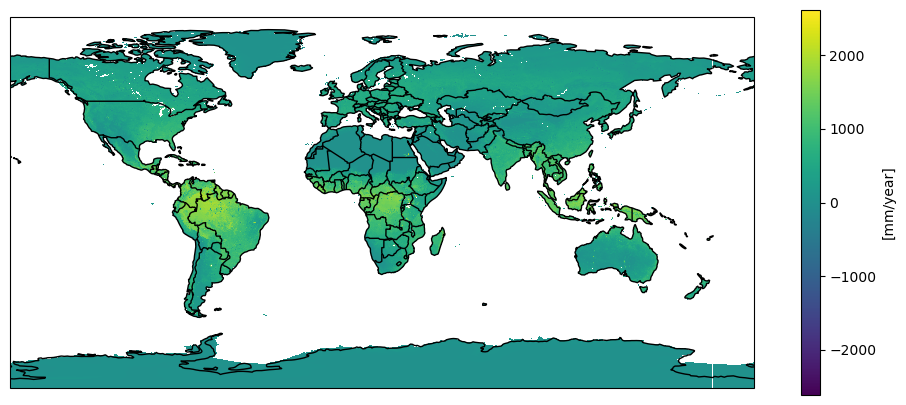

In [30]:
ax = aet.create_plot(central_longitude=20, figsize=(12,5))

cmap = 'viridis'
fig = aet.plot_mean(ax=ax, coastline=True, borders=True, colorbar=True,
                  colorbar_label=f'[{aet.units}]', cmap=cmap, central_longitude=20, central_latitude=0)

## Zoom in to your location
You can zoom in to your location by using the crop function.  
`.getCropped(from_lat=80, to_lat=120, from_lon=0, to_lon=90)`

In [31]:
cropped_aet = aet.getCropped(from_lat=0, to_lat=90, from_lon=60, to_lon=140)

Cropping meteorology...
    Done.


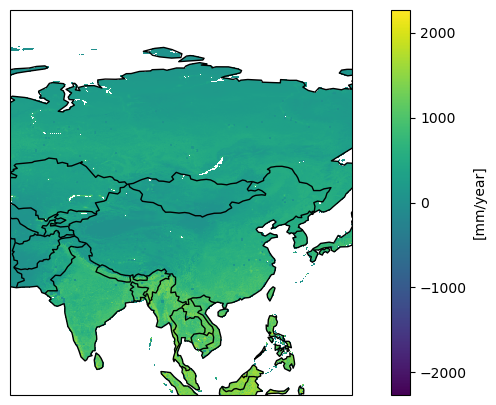

In [32]:
ax = cropped_aet.create_plot(central_longitude=20, figsize=(10,5))

cmap = 'viridis'
fig = cropped_aet.plot_mean(ax=ax, coastline=True, borders=True, colorbar=True,
                  colorbar_label=f'[{aet.units}]', cmap=cmap, central_longitude=20, central_latitude=0)

## You can read several years at once and join them too
To accomplish this, use the `.join()` function in a loop that goes through all your AET files from gleam.   
Download them here:  
https://fenix.tecnico.ulisboa.pt/disciplinas/HRH/2024-2025/1-semestre/assignements

In [39]:
gleam_files_path = Path(r'./additional/')

aet_all = None
for f0 in gleam_files_path.glob('*.nc'):
    print(f0.name)
    
    tmp = read_gleam(f0)
    if aet_all is None:
        aet_all = tmp
    else:
        aet_all.join(tmp)

# Save for later use
aet_all.save('gleam_aet.mr')

E_2021_GLEAM_v4.2a_YR.nc
E_2022_GLEAM_v4.2a_YR.nc
E_2023_GLEAM_v4.2a_YR.nc
    Saving gleam_aet.mr...
        Saved.


In [40]:
aet_all = MeteoRaster.load('gleam_aet.mr')

    Loading gleam_aet.mr...
        Loaded.


## Finally, get a time series for your location
Shanghai can be an example:  
31.2 N and 121.4 E

Leadtime,<DateOffset: days=0>
Ensemble member,0
Production dates,
2021-12-31,386.800385
2022-12-31,384.561798
2023-12-31,368.568359


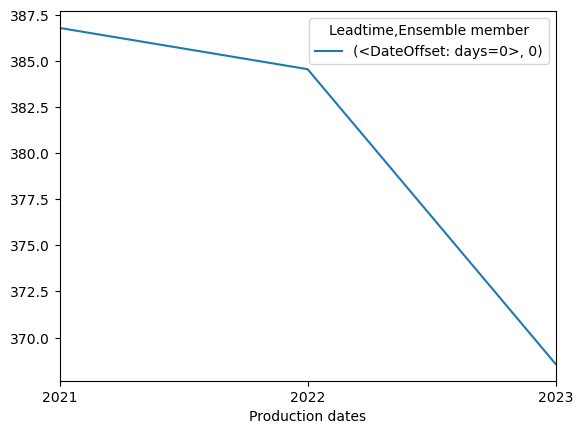

In [47]:
aet_series = aet_all.getDataFromLatLon(31.2, 121.4)
aet_series.plot()
aet_series

## Now do this far all the GLEAM AET files and campute the mean over the center of your catchment 